In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
T=np.array([[1,.1,0],[0,.7,0],[0,.2,1]])
eigs=np.linalg.eig(T)
Lambda=np.diag(eigs[0])
Q=eigs[1]
Q_inverse=np.linalg.inv(Q)
Pi_0=np.array([0,.9,.1])
np.round(Q@np.linalg.matrix_power(Lambda,200)@Q_inverse@Pi_0,5)


array([0.3, 0. , 0.7])

Text(0, 0.5, '% per state')

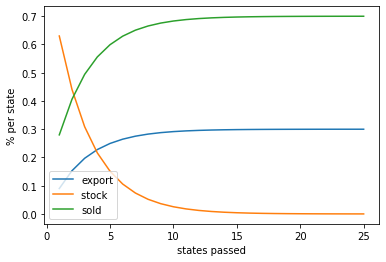

In [3]:
y=np.linspace(1,25,25)
x=[]
for i in y:
    x.append(np.round(Q@np.linalg.matrix_power(Lambda,int(i))@Q_inverse@Pi_0,5))
plt.plot(y,x[0:])
plt.legend(["export", "stock ","sold"])
plt.xlabel("states passed")
plt.ylabel("% per state")

In [1]:
import numpy as np
from collections import Counter

from sympy import denom

def data_loader():
    # load data
    with open('train','r') as file:
        train_data = file.read().split('\n')[:-1]
    with open('test','r') as file:
        test_data = file.read().split('\n')[:-1]
    return train_data, test_data

def parser(datum):
    # extract labels and words
    email_addr, label, words = datum.split(' ',2)
    words = words.split()
    # transform words into dictionary
    word_dict = dict(zip([words[i] for i in range(0, len(words), 2)], [int(words[i+1]) for i in range(0, len(words), 2)]))
    # transform label into 0, 1
    if label == 'ham':
        label = 0
    elif label == 'spam':
        label = 1
    else: 
        raise ValueError
    return label, word_dict

def data_preprocessing(train_data, test_data):
    y_train = np.zeros(len(train_data))
    y_test = np.zeros(len(test_data))
    x_train = []
    x_test = []
    for i, datum in enumerate(train_data):
        label, word_dict = parser(datum)
        y_train[i] = label
        x_train.append(word_dict)
    for i, datum in enumerate(test_data):
        label, word_dict = parser(datum)
        y_test[i] = label
        x_test.append(word_dict)
    return x_train, y_train, x_test, y_test

def compute_empirical_pmf_y(y_train):
    # compte distribution P(y=1), P(y=0)
    # TODO
    x=len(np.where(y_train==1)[0])/len(y_train)
    y=len(np.where(y_train==0)[0])/len(y_train)
    return x,y

def m_estimation_conditional_probability(x_train_frt, y_train, num_vocab, m):
    # compute P(x_j|y=1) and P(x_j|y=0) for j = 1, ..., d
    # TODO
    p_on_spam_m=[]
    p_on_ham_m=[]
    for i in range(num_vocab):
        a=np.argwhere(x_train_frt[:,i]>=1) ## ie where x=1
        b=np.argwhere(y_train>=1) ## ie where y=1
        d=np.argwhere(y_train<1) ## ie where y=0
        c=np.intersect1d(a,b) ## so this is x=1,y=1
        e=np.intersect1d(a,d) ## this is x=1,y=0
        numerator=len(c)+m ## this is number of cases in x=1,y=0 plus the m factor+m
        denominator=len(b)+(m*num_vocab) ## this si number of cases where y=1
        numerator_2=len(e)+m ## this is count(x=1,y=0)+ m
        denominator_2=len(d)+(m*num_vocab) # this si count y=0
        #p_on_spam_m.append(np.sum(y_train[x_train_frt[:,i]>0]==1)+m/ np.sum(y_train==1)+m*num_vocab)
        #p_on_ham_m.append(np.sum(y_train[x_train_frt[:,i]>0]==0)+m/ np.sum(y_train==0)+m*num_vocab)
        p_on_spam_m.append(numerator/denominator) ## then the ratio of these two.  makes sense since y=1
        p_on_ham_m.append(numerator_2/denominator_2) ## add the ratio of these two.  makes sense since y=0
    return p_on_spam_m,p_on_ham_m

def log_estimated_probability(p_spam, p_ham, p_on_spam_m, p_on_ham_m, x_frts):
    # compute log(P(y=1, x_1, x_2,..., x_n)) and log(P(y=0, x_1, x_2,..., x_n))
    # hint: log(P(y, x_1, x_2,..., x_n)) = log(P(y=1)) + log(P(x_1 | y)) + ... + log(P(x_d | y))
    # TODO
    out_spam=[]
    out_ham=[]
    for row in x_frts:
        temp_spam=np.log10(p_spam)
        temp_ham=np.log10(p_ham) ## start off with teh low of the rar probabilities/ 
        for word in range(len(row)):
            if(row[word]==0): ## if the word is not present 
                #if(p_on_spam_m[word]<(1-0.0000000001)):
                temp_spam=temp_spam+np.log10(1-p_on_spam_m[word]) ## P(x=0|y=1)=1-P(x=1|y=1) by law of total probability? 
                #if(p_on_ham_m[word]<(1-0.0000000001)):
                temp_ham=temp_ham+np.log10(1-p_on_ham_m[word])
            else:
                #if(p_on_spam_m[word]> 0.0000000001):
                temp_spam=temp_spam+np.log10(p_on_spam_m[word])
                #if(p_on_ham_m[word]> 0.0000000001):
                temp_ham=temp_ham+np.log10(p_on_ham_m[word])
        out_spam.append(temp_spam)
        out_ham.append(temp_ham)
    return np.array(out_spam),np.array(out_ham)

def accuarcy(y_true, y_pred):
    # calculate accuracy
    # TODO 
    return len(np.argwhere(y_true==y_pred))/len(y_pred)

In [2]:
from sklearn.feature_extraction import DictVectorizer
# load data
train_data, test_data = data_loader()
# extract labels to 0,1 and features to dicticnary
x_train, y_train, x_test, y_test = data_preprocessing(train_data, test_data)

# transform word dicts to feature vectors
vectorizer = DictVectorizer(sparse=False)

x_train_frt = vectorizer.fit_transform(x_train)
x_test_frt = vectorizer.transform(x_test)
print(x_train_frt.shape, x_test_frt.shape)


(9000, 1000) (1000, 1000)


In [3]:
def pipeline(x_train_frt, y_train, x_test_frt, y_test, m):
    print(m)
    p_spam, p_ham = compute_empirical_pmf_y(y_train)
    p_on_spam_m, p_on_ham_m = m_estimation_conditional_probability(x_train_frt, y_train, x_train_frt.shape[1], m)
    log_p_spam, log_p_ham = log_estimated_probability(p_spam, p_ham, p_on_spam_m, p_on_ham_m, x_test_frt)
    test_pred = (log_p_spam > log_p_ham)
    print(str(m) + ":" + str(accuarcy(y_test, test_pred)))

m_grid = [0, 0.01, 0.1, 1, 10, 100, 1000 ]
for m in m_grid:
    pipeline(x_train_frt, y_train, x_test_frt, y_test, m)

0


C:\Users\buzga\AppData\Local\Temp/ipykernel_11556/474062043.py:84: RuntimeWarning: divide by zero encountered in log10
  temp_spam=temp_spam+np.log10(1-p_on_spam_m[word]) ## P(x=0|y=1)=1-P(x=1|y=1) by law of total probability?
C:\Users\buzga\AppData\Local\Temp/ipykernel_11556/474062043.py:89: RuntimeWarning: divide by zero encountered in log10
  temp_spam=temp_spam+np.log10(p_on_spam_m[word])


0:0.932
0.01
0.01:0.927
0.1
0.1:0.924
1
1:0.922
10
10:0.905
100
100:0.88
1000
1000:0.845
